## MOLGAN EXAMPLE

In [1]:
import tensorflow as tf

from utils.sparse_molecular_dataset import SparseMolecularDataset
from utils.trainer import Trainer
from utils.utils import *

from models.gan import GraphGANModel
from models import encoder_rgcn, decoder_adj, decoder_dot, decoder_rnn

from optimizers.gan import GraphGANOptimizer

batch_dim = 128
la = 1
dropout = 0
n_critic = 5
metric = 'validity,sas'
n_samples = 1000
z_dim = 8
epochs = 100
save_every = 1 # May lead to errors if left as None

data = SparseMolecularDataset()
data.load('data/oe62_9nodes.sparsedataset')

steps = (len(data) // batch_dim)


def train_fetch_dict(i, steps, epoch, epochs, min_epochs, model, optimizer):
    a = [optimizer.train_step_G] if i % n_critic == 0 else [optimizer.train_step_D]
    b = [optimizer.train_step_V] if i % n_critic == 0 and la < 1 else []
    return a + b


def train_feed_dict(i, steps, epoch, epochs, min_epochs, model, optimizer, batch_dim):
    mols, _, _, a, x, _, _, _, _ = data.next_train_batch(batch_dim)
    embeddings = model.sample_z(batch_dim)

    if la < 1:

        if i % n_critic == 0:
            rewardR = reward(mols)

            n, e = session.run([model.nodes_gumbel_argmax, model.edges_gumbel_argmax],
                               feed_dict={model.training: False, model.embeddings: embeddings})
            n, e = np.argmax(n, axis=-1), np.argmax(e, axis=-1)
            mols = [data.matrices2mol(n_, e_, strict=True) for n_, e_ in zip(n, e)]

            rewardF = reward(mols)

            feed_dict = {model.edges_labels: a,
                         model.nodes_labels: x,
                         model.embeddings: embeddings,
                         model.rewardR: rewardR,
                         model.rewardF: rewardF,
                         model.training: True,
                         model.dropout_rate: dropout,
                         optimizer.la: la if epoch > 0 else 1.0}

        else:
            feed_dict = {model.edges_labels: a,
                         model.nodes_labels: x,
                         model.embeddings: embeddings,
                         model.training: True,
                         model.dropout_rate: dropout,
                         optimizer.la: la if epoch > 0 else 1.0}
    else:
        feed_dict = {model.edges_labels: a,
                     model.nodes_labels: x,
                     model.embeddings: embeddings,
                     model.training: True,
                     model.dropout_rate: dropout,
                     optimizer.la: 1.0}

    return feed_dict


def eval_fetch_dict(i, epochs, min_epochs, model, optimizer):
    return {'loss D': optimizer.loss_D, 'loss G': optimizer.loss_G,
            'loss RL': optimizer.loss_RL, 'loss V': optimizer.loss_V,
            'la': optimizer.la}


def eval_feed_dict(i, epochs, min_epochs, model, optimizer, batch_dim):
    mols, _, _, a, x, _, _, _, _ = data.next_validation_batch()
    embeddings = model.sample_z(a.shape[0])

    rewardR = reward(mols)

    n, e = session.run([model.nodes_gumbel_argmax, model.edges_gumbel_argmax],
                       feed_dict={model.training: False, model.embeddings: embeddings})
    n, e = np.argmax(n, axis=-1), np.argmax(e, axis=-1)
    mols = [data.matrices2mol(n_, e_, strict=True) for n_, e_ in zip(n, e)]

    rewardF = reward(mols)

    feed_dict = {model.edges_labels: a,
                 model.nodes_labels: x,
                 model.embeddings: embeddings,
                 model.rewardR: rewardR,
                 model.rewardF: rewardF,
                 model.training: False}
    return feed_dict


def test_fetch_dict(model, optimizer):
    return {'loss D': optimizer.loss_D, 'loss G': optimizer.loss_G,
            'loss RL': optimizer.loss_RL, 'loss V': optimizer.loss_V,
            'la': optimizer.la}


def test_feed_dict(model, optimizer, batch_dim):
    mols, _, _, a, x, _, _, _, _ = data.next_test_batch()
    embeddings = model.sample_z(a.shape[0])

    rewardR = reward(mols)

    n, e = session.run([model.nodes_gumbel_argmax, model.edges_gumbel_argmax],
                       feed_dict={model.training: False, model.embeddings: embeddings})
    n, e = np.argmax(n, axis=-1), np.argmax(e, axis=-1)
    mols = [data.matrices2mol(n_, e_, strict=True) for n_, e_ in zip(n, e)]

    rewardF = reward(mols)

    feed_dict = {model.edges_labels: a,
                 model.nodes_labels: x,
                 model.embeddings: embeddings,
                 model.rewardR: rewardR,
                 model.rewardF: rewardF,
                 model.training: False}
    return feed_dict


def reward(mols):
    rr = 1.
    for m in ('logp,sas,qed,unique' if metric == 'all' else metric).split(','):

        if m == 'np':
            rr *= MolecularMetrics.natural_product_scores(mols, norm=True)
        #elif m == 'logp':
        #    rr *= MolecularMetrics.water_octanol_partition_coefficient_scores(mols, norm=True)
        elif m == 'sas':
            rr *= MolecularMetrics.synthetic_accessibility_score_scores(mols, norm=True)
        #elif m == 'qed':
        #    rr *= MolecularMetrics.quantitative_estimation_druglikeness_scores(mols, norm=True)
        elif m == 'novelty':
            rr *= MolecularMetrics.novel_scores(mols, data)
        #elif m == 'dc':
        #    rr *= MolecularMetrics.drugcandidate_scores(mols, data)
        elif m == 'unique':
            rr *= MolecularMetrics.unique_scores(mols)
        elif m == 'diversity':
            rr *= MolecularMetrics.diversity_scores(mols, data)
        elif m == 'validity':
            rr *= MolecularMetrics.valid_scores(mols)
        else:
            raise RuntimeError('{} is not defined as a metric'.format(m))

    return rr.reshape(-1, 1)


def _eval_update(i, epochs, min_epochs, model, optimizer, batch_dim, eval_batch):
    mols = samples(data, model, session, model.sample_z(n_samples), sample=True)
    m0, m1 = all_scores(mols, data, norm=True)
    m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
    m0.update(m1)
    return m0


def _test_update(model, optimizer, batch_dim, test_batch):
    mols = samples(data, model, session, model.sample_z(n_samples), sample=True)
    m0, m1 = all_scores(mols, data, norm=True)
    m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
    m0.update(m1)
    return m0


# model
model = GraphGANModel(data.vertexes,
                      data.bond_num_types,
                      data.atom_num_types,
                      z_dim,
                      decoder_units=(128, 256, 512),
                      discriminator_units=((128, 64), 128, (128, 64)),
                      decoder=decoder_adj,
                      discriminator=encoder_rgcn,
                      soft_gumbel_softmax=False,
                      hard_gumbel_softmax=False,
                      batch_discriminator=False)

# optimizer
optimizer = GraphGANOptimizer(model, learning_rate=1e-3, feature_matching=False)

# session
session = tf.Session()
session.run(tf.global_variables_initializer())

# trainer
trainer = Trainer(model, optimizer, session)

print('Parameters: {}'.format(np.sum([np.prod(e.shape) for e in session.run(tf.trainable_variables())])))

trainer.train(batch_dim=batch_dim,
              epochs=epochs,
              steps=steps,
              train_fetch_dict=train_fetch_dict,
              train_feed_dict=train_feed_dict,
              eval_fetch_dict=eval_fetch_dict,
              eval_feed_dict=eval_feed_dict,
              test_fetch_dict=test_fetch_dict,
              test_feed_dict=test_feed_dict,
              save_every=save_every,
              directory='Model_Output', # here users need to first create and then specify a folder where to save the model
              _eval_update=_eval_update,
              _test_update=_test_update)





Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




2025-07-22 13:31:26.268715: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-22 13:31:26.274367: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999965000 Hz
2025-07-22 13:31:26.274784: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5635348d3cf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-07-22 13:31:26.274811: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-7
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 8 available OS procs
OMP: Info #158: KMP_AFFINITY: Uniform topology
OMP: Info 


Parameters: 3416930
2025-07-22 13:31:27 Epochs          0/100 in 0:00:00 (last epoch in 0:00:00), ETA: -:--:-


OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15898 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15902 thread 2 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15903 thread 3 bound to OS proc set 3
OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15904 thread 4 bound to OS proc set 4
OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15899 thread 5 bound to OS proc set 5
OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15905 thread 6 bound to OS proc set 6
OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15906 thread 7 bound to OS proc set 7
OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15907 thread 8 bound to OS proc set 0
OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15908 thread 9 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15909 thread 10 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15910 thread 11 bound to OS proc set 3
OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15911 thread 12 bound to OS proc set 4
[13:31:27] Ex

2025-07-22 13:31:30 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': 0.9123229,
 'loss G': -0.36511305,
 'loss RL': -0.46722618,
 'loss V': 0.3193454,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}



/home/silkenmocha/Documentos/MolGAN-OE62/utils/molecular_metrics.py:60: RuntimeWarning: Mean of empty slice.
  return MolecularMetrics.novel_scores(MolecularMetrics.valid_filter(mols), data).mean()
/home/silkenmocha/anaconda3/envs/molgan/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/silkenmocha/anaconda3/envs/molgan/lib/python3.7/site-packages/ipykernel_launcher.py:164: RuntimeWarning: Mean of empty slice.


2025-07-22 13:31:31 Model saved in Model_Output!


OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15942 thread 13 bound to OS proc set 5
OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15943 thread 14 bound to OS proc set 6
OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15944 thread 15 bound to OS proc set 7
OMP: Info #254: KMP_AFFINITY: pid 15848 tid 15945 thread 16 bound to OS proc set 0


 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:31:39 Epochs          1/100 in 0:00:12 (last epoch in 0:00:08), ETA: 0:20:38


[13:31:40] Explicit valence for atom # 0 O, 54, is greater than permitted
[13:31:40] Explicit valence for atom # 1 C, 56, is greater than permitted
[13:31:40] Explicit valence for atom # 1 N, 47, is greater than permitted
[13:31:40] Explicit valence for atom # 0 P, 63, is greater than permitted
[13:31:40] Explicit valence for atom # 0 C, 47, is greater than permitted
[13:31:40] Explicit valence for atom # 0 S, 53, is greater than permitted
[13:31:40] Explicit valence for atom # 0 P, 51, is greater than permitted
[13:31:40] Explicit valence for atom # 0 P, 46, is greater than permitted
[13:31:40] Explicit valence for atom # 0 C, 40, is greater than permitted
[13:31:40] Explicit valence for atom # 0 N, 52, is greater than permitted
[13:31:40] Explicit valence for atom # 0 S, 52, is greater than permitted
[13:31:40] Explicit valence for atom # 1 O, 42, is greater than permitted
[13:31:40] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:31:40] Explicit valence for atom #

2025-07-22 13:31:41 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -0.9964338,
 'loss G': 0.30060822,
 'loss RL': -0.41559878,
 'loss V': 0.28032196,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:31:42 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:31:43 Epochs          2/100 in 0:00:16 (last epoch in 0:00:01), ETA: 0:13:29


[13:31:44] Explicit valence for atom # 0 C, 50, is greater than permitted
[13:31:44] Explicit valence for atom # 0 S, 50, is greater than permitted
[13:31:44] Explicit valence for atom # 1 C, 46, is greater than permitted
[13:31:44] Explicit valence for atom # 1 S, 61, is greater than permitted
[13:31:44] Explicit valence for atom # 0 C, 44, is greater than permitted
[13:31:44] Explicit valence for atom # 0 O, 56, is greater than permitted
[13:31:44] Explicit valence for atom # 0 P, 56, is greater than permitted
[13:31:44] Explicit valence for atom # 0 P, 48, is greater than permitted
[13:31:44] Explicit valence for atom # 0 O, 49, is greater than permitted
[13:31:44] Explicit valence for atom # 0 S, 56, is greater than permitted
[13:31:44] Explicit valence for atom # 0 O, 44, is greater than permitted
[13:31:44] Explicit valence for atom # 0 O, 45, is greater than permitted
[13:31:44] Explicit valence for atom # 0 P, 45, is greater than permitted
[13:31:44] Explicit valence for atom #

2025-07-22 13:31:45 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -3.1989527,
 'loss G': 1.3490037,
 'loss RL': -0.39992538,
 'loss V': 0.27053204,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:31:46 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:31:48 Epochs          3/100 in 0:00:20 (last epoch in 0:00:01), ETA: 0:11:08


[13:31:48] Explicit valence for atom # 0 P, 50, is greater than permitted
[13:31:48] Explicit valence for atom # 0 P, 47, is greater than permitted
[13:31:48] Explicit valence for atom # 0 C, 46, is greater than permitted
[13:31:48] Explicit valence for atom # 0 C, 42, is greater than permitted
[13:31:48] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:31:48] Explicit valence for atom # 0 C, 48, is greater than permitted
[13:31:48] Explicit valence for atom # 0 P, 52, is greater than permitted
[13:31:48] Explicit valence for atom # 0 N, 37, is greater than permitted
[13:31:48] Explicit valence for atom # 0 S, 52, is greater than permitted
[13:31:48] Explicit valence for atom # 0 O, 64, is greater than permitted
[13:31:48] Explicit valence for atom # 0 N, 51, is greater than permitted
[13:31:48] Explicit valence for atom # 0 S, 52, is greater than permitted
[13:31:48] Explicit valence for atom # 0 O, 53, is greater than permitted
[13:31:48] Explicit valence for atom #

2025-07-22 13:31:49 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -5.2648735,
 'loss G': 2.1976013,
 'loss RL': -0.39671287,
 'loss V': 0.26812348,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:31:50 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:31:52 Epochs          4/100 in 0:00:24 (last epoch in 0:00:01), ETA: 0:09:54


[13:31:52] Explicit valence for atom # 0 N, 39, is greater than permitted
[13:31:52] Explicit valence for atom # 1 C, 55, is greater than permitted
[13:31:52] Explicit valence for atom # 0 P, 52, is greater than permitted
[13:31:52] Explicit valence for atom # 1 S, 46, is greater than permitted
[13:31:52] Explicit valence for atom # 0 N, 56, is greater than permitted
[13:31:52] Explicit valence for atom # 0 P, 46, is greater than permitted
[13:31:52] Explicit valence for atom # 0 N, 52, is greater than permitted
[13:31:52] Explicit valence for atom # 0 C, 51, is greater than permitted
[13:31:52] Explicit valence for atom # 0 O, 44, is greater than permitted
[13:31:52] Explicit valence for atom # 1 P, 51, is greater than permitted
[13:31:52] Explicit valence for atom # 0 C, 46, is greater than permitted
[13:31:52] Explicit valence for atom # 0 P, 50, is greater than permitted
[13:31:52] Explicit valence for atom # 1 O, 40, is greater than permitted
[13:31:52] Explicit valence for atom #

2025-07-22 13:31:53 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -7.1772733,
 'loss G': 2.98309,
 'loss RL': -0.3885366,
 'loss V': 0.2612238,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:31:54 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:31:56 Epochs          5/100 in 0:00:28 (last epoch in 0:00:01), ETA: 0:09:10


[13:31:56] Explicit valence for atom # 0 N, 51, is greater than permitted
[13:31:56] Explicit valence for atom # 0 C, 48, is greater than permitted
[13:31:56] Explicit valence for atom # 0 P, 46, is greater than permitted
[13:31:56] Explicit valence for atom # 0 P, 65, is greater than permitted
[13:31:56] Explicit valence for atom # 0 O, 49, is greater than permitted
[13:31:56] Explicit valence for atom # 1 O, 50, is greater than permitted
[13:31:56] Explicit valence for atom # 0 S, 46, is greater than permitted
[13:31:56] Explicit valence for atom # 0 O, 48, is greater than permitted
[13:31:56] Explicit valence for atom # 0 N, 39, is greater than permitted
[13:31:56] Explicit valence for atom # 0 N, 54, is greater than permitted
[13:31:56] Explicit valence for atom # 0 P, 53, is greater than permitted
[13:31:56] Explicit valence for atom # 0 C, 50, is greater than permitted
[13:31:56] Explicit valence for atom # 1 P, 46, is greater than permitted
[13:31:56] Explicit valence for atom #

2025-07-22 13:31:58 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -9.286017,
 'loss G': 3.9799783,
 'loss RL': -0.35966316,
 'loss V': 0.23923834,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:31:59 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:32:00 Epochs          6/100 in 0:00:33 (last epoch in 0:00:01), ETA: 0:08:39


[13:32:00] Explicit valence for atom # 0 P, 56, is greater than permitted
[13:32:00] Explicit valence for atom # 1 P, 46, is greater than permitted
[13:32:00] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:32:00] Explicit valence for atom # 0 O, 44, is greater than permitted
[13:32:00] Explicit valence for atom # 0 N, 46, is greater than permitted
[13:32:00] Explicit valence for atom # 0 P, 55, is greater than permitted
[13:32:00] Explicit valence for atom # 0 N, 51, is greater than permitted
[13:32:00] Explicit valence for atom # 0 P, 53, is greater than permitted
[13:32:00] Explicit valence for atom # 0 N, 54, is greater than permitted
[13:32:00] Explicit valence for atom # 0 S, 60, is greater than permitted
[13:32:00] Explicit valence for atom # 0 S, 51, is greater than permitted
[13:32:00] Explicit valence for atom # 0 S, 46, is greater than permitted
[13:32:00] Explicit valence for atom # 0 P, 51, is greater than permitted
[13:32:00] Explicit valence for atom #

2025-07-22 13:32:02 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -10.458582,
 'loss G': 4.409629,
 'loss RL': -0.36116052,
 'loss V': 0.23895107,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:32:03 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:32:04 Epochs          7/100 in 0:00:37 (last epoch in 0:00:01), ETA: 0:08:17


[13:32:05] Explicit valence for atom # 0 C, 56, is greater than permitted
[13:32:05] Explicit valence for atom # 0 N, 50, is greater than permitted
[13:32:05] Explicit valence for atom # 0 N, 51, is greater than permitted
[13:32:05] Explicit valence for atom # 0 O, 58, is greater than permitted
[13:32:05] Explicit valence for atom # 0 P, 48, is greater than permitted
[13:32:05] Explicit valence for atom # 0 S, 57, is greater than permitted
[13:32:05] Explicit valence for atom # 0 S, 55, is greater than permitted
[13:32:05] Explicit valence for atom # 1 S, 50, is greater than permitted
[13:32:05] Explicit valence for atom # 1 C, 48, is greater than permitted
[13:32:05] Explicit valence for atom # 0 P, 45, is greater than permitted
[13:32:05] Explicit valence for atom # 0 S, 60, is greater than permitted
[13:32:05] Explicit valence for atom # 0 S, 39, is greater than permitted
[13:32:05] Explicit valence for atom # 0 O, 49, is greater than permitted
[13:32:05] Explicit valence for atom #

2025-07-22 13:32:06 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -11.472574,
 'loss G': 4.7871423,
 'loss RL': -0.38460183,
 'loss V': 0.26652965,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:32:07 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:32:09 Epochs          8/100 in 0:00:41 (last epoch in 0:00:01), ETA: 0:08:00


[13:32:09] Explicit valence for atom # 0 N, 49, is greater than permitted
[13:32:09] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:32:09] Explicit valence for atom # 0 P, 50, is greater than permitted
[13:32:09] Explicit valence for atom # 0 P, 53, is greater than permitted
[13:32:09] Explicit valence for atom # 1 S, 45, is greater than permitted
[13:32:09] Explicit valence for atom # 1 P, 45, is greater than permitted
[13:32:09] Explicit valence for atom # 0 O, 64, is greater than permitted
[13:32:09] Explicit valence for atom # 0 S, 60, is greater than permitted
[13:32:09] Explicit valence for atom # 0 O, 58, is greater than permitted
[13:32:09] Explicit valence for atom # 0 P, 53, is greater than permitted
[13:32:09] Explicit valence for atom # 0 S, 52, is greater than permitted
[13:32:09] Explicit valence for atom # 0 C, 37, is greater than permitted
[13:32:09] Explicit valence for atom # 0 S, 46, is greater than permitted
[13:32:09] Explicit valence for atom #

2025-07-22 13:32:10 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -13.262224,
 'loss G': 5.765773,
 'loss RL': -0.42143536,
 'loss V': 0.29709372,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:32:12 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:32:13 Epochs          9/100 in 0:00:46 (last epoch in 0:00:01), ETA: 0:07:45


[13:32:13] Explicit valence for atom # 0 P, 57, is greater than permitted
[13:32:13] Explicit valence for atom # 0 S, 43, is greater than permitted
[13:32:13] Explicit valence for atom # 0 N, 43, is greater than permitted
[13:32:13] Explicit valence for atom # 0 S, 46, is greater than permitted
[13:32:13] Explicit valence for atom # 0 S, 49, is greater than permitted
[13:32:13] Explicit valence for atom # 0 C, 63, is greater than permitted
[13:32:13] Explicit valence for atom # 0 O, 60, is greater than permitted
[13:32:13] Explicit valence for atom # 0 C, 55, is greater than permitted
[13:32:13] Explicit valence for atom # 0 P, 57, is greater than permitted
[13:32:13] Explicit valence for atom # 0 S, 47, is greater than permitted
[13:32:13] Explicit valence for atom # 0 O, 36, is greater than permitted
[13:32:13] Explicit valence for atom # 0 C, 61, is greater than permitted
[13:32:13] Explicit valence for atom # 0 N, 39, is greater than permitted
[13:32:13] Explicit valence for atom #

2025-07-22 13:32:15 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -14.370043,
 'loss G': 6.324844,
 'loss RL': -0.44143906,
 'loss V': 0.31843176,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:32:16 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:32:17 Epochs         10/100 in 0:00:50 (last epoch in 0:00:01), ETA: 0:07:34


[13:32:18] Explicit valence for atom # 0 S, 32, is greater than permitted
[13:32:18] Explicit valence for atom # 0 N, 33, is greater than permitted
[13:32:18] Explicit valence for atom # 0 P, 43, is greater than permitted
[13:32:18] Explicit valence for atom # 0 S, 42, is greater than permitted
[13:32:18] Explicit valence for atom # 0 S, 42, is greater than permitted
[13:32:18] Explicit valence for atom # 0 N, 42, is greater than permitted
[13:32:18] Explicit valence for atom # 0 N, 59, is greater than permitted
[13:32:18] Explicit valence for atom # 0 O, 43, is greater than permitted
[13:32:18] Explicit valence for atom # 0 S, 50, is greater than permitted
[13:32:18] Explicit valence for atom # 0 C, 43, is greater than permitted
[13:32:18] Explicit valence for atom # 0 N, 41, is greater than permitted
[13:32:18] Explicit valence for atom # 0 C, 50, is greater than permitted
[13:32:18] Explicit valence for atom # 0 P, 53, is greater than permitted
[13:32:18] Explicit valence for atom #

2025-07-22 13:32:19 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -15.641879,
 'loss G': 7.036269,
 'loss RL': -0.44770557,
 'loss V': 0.3265118,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:32:21 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:32:22 Epochs         11/100 in 0:00:55 (last epoch in 0:00:01), ETA: 0:07:27


[13:32:22] Explicit valence for atom # 0 S, 46, is greater than permitted
[13:32:22] Explicit valence for atom # 0 P, 56, is greater than permitted
[13:32:22] Explicit valence for atom # 0 S, 42, is greater than permitted
[13:32:22] Explicit valence for atom # 0 P, 55, is greater than permitted
[13:32:22] Explicit valence for atom # 0 C, 43, is greater than permitted
[13:32:22] Explicit valence for atom # 0 S, 44, is greater than permitted
[13:32:22] Explicit valence for atom # 0 P, 56, is greater than permitted
[13:32:22] Explicit valence for atom # 1 P, 49, is greater than permitted
[13:32:22] Explicit valence for atom # 0 N, 45, is greater than permitted
[13:32:22] Explicit valence for atom # 0 P, 63, is greater than permitted
[13:32:22] Explicit valence for atom # 0 C, 52, is greater than permitted
[13:32:22] Explicit valence for atom # 0 S, 50, is greater than permitted
[13:32:22] Explicit valence for atom # 0 N, 56, is greater than permitted
[13:32:22] Explicit valence for atom #

2025-07-22 13:32:24 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -16.129702,
 'loss G': 7.0492387,
 'loss RL': -0.41628653,
 'loss V': 0.2883103,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:32:26 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:32:28 Epochs         12/100 in 0:01:00 (last epoch in 0:00:01), ETA: 0:07:24


[13:32:28] Explicit valence for atom # 1 P, 66, is greater than permitted
[13:32:28] Explicit valence for atom # 1 S, 43, is greater than permitted
[13:32:28] Explicit valence for atom # 3 P, 51, is greater than permitted
[13:32:28] Explicit valence for atom # 0 P, 55, is greater than permitted
[13:32:28] Explicit valence for atom # 0 S, 45, is greater than permitted
[13:32:28] Explicit valence for atom # 0 P, 58, is greater than permitted
[13:32:28] Explicit valence for atom # 0 P, 58, is greater than permitted
[13:32:28] Explicit valence for atom # 0 O, 45, is greater than permitted
[13:32:28] Explicit valence for atom # 0 P, 54, is greater than permitted
[13:32:28] Explicit valence for atom # 0 S, 44, is greater than permitted
[13:32:28] Explicit valence for atom # 0 S, 43, is greater than permitted
[13:32:28] Explicit valence for atom # 0 S, 48, is greater than permitted
[13:32:28] Explicit valence for atom # 0 S, 42, is greater than permitted
[13:32:28] Explicit valence for atom #

2025-07-22 13:32:30 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -17.255175,
 'loss G': 7.704096,
 'loss RL': -0.42220914,
 'loss V': 0.2891289,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:32:31 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:32:33 Epochs         13/100 in 0:01:06 (last epoch in 0:00:02), ETA: 0:07:23


[13:32:33] Explicit valence for atom # 0 P, 63, is greater than permitted
[13:32:33] Explicit valence for atom # 0 N, 62, is greater than permitted
[13:32:33] Explicit valence for atom # 1 C, 62, is greater than permitted
[13:32:33] Explicit valence for atom # 0 P, 64, is greater than permitted
[13:32:33] Explicit valence for atom # 1 C, 58, is greater than permitted
[13:32:33] Explicit valence for atom # 4 C, 50, is greater than permitted
[13:32:33] Explicit valence for atom # 1 S, 45, is greater than permitted
[13:32:33] Explicit valence for atom # 0 S, 43, is greater than permitted
[13:32:33] Explicit valence for atom # 0 S, 43, is greater than permitted
[13:32:33] Explicit valence for atom # 1 C, 56, is greater than permitted
[13:32:33] Explicit valence for atom # 0 P, 62, is greater than permitted
[13:32:33] Explicit valence for atom # 0 P, 73, is greater than permitted
[13:32:33] Explicit valence for atom # 1 P, 62, is greater than permitted
[13:32:33] Explicit valence for atom #

2025-07-22 13:32:35 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -18.439981,
 'loss G': 8.371545,
 'loss RL': -0.4048258,
 'loss V': 0.27390048,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:32:37 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:32:38 Epochs         14/100 in 0:01:11 (last epoch in 0:00:01), ETA: 0:07:16


[13:32:38] Explicit valence for atom # 1 P, 60, is greater than permitted
[13:32:38] Explicit valence for atom # 0 P, 65, is greater than permitted
[13:32:38] Explicit valence for atom # 0 S, 46, is greater than permitted
[13:32:38] Explicit valence for atom # 0 S, 47, is greater than permitted
[13:32:38] Explicit valence for atom # 0 N, 50, is greater than permitted
[13:32:38] Explicit valence for atom # 0 C, 47, is greater than permitted
[13:32:38] Explicit valence for atom # 0 P, 66, is greater than permitted
[13:32:38] Explicit valence for atom # 0 S, 53, is greater than permitted
[13:32:38] Explicit valence for atom # 0 O, 63, is greater than permitted
[13:32:38] Explicit valence for atom # 1 P, 66, is greater than permitted
[13:32:38] Explicit valence for atom # 0 C, 47, is greater than permitted
[13:32:38] Explicit valence for atom # 0 S, 44, is greater than permitted
[13:32:38] Explicit valence for atom # 0 S, 58, is greater than permitted
[13:32:38] Explicit valence for atom #

2025-07-22 13:32:40 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -19.321701,
 'loss G': 8.7414255,
 'loss RL': -0.414785,
 'loss V': 0.2851423,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:32:41 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:32:43 Epochs         15/100 in 0:01:15 (last epoch in 0:00:01), ETA: 0:07:10


[13:32:43] Explicit valence for atom # 0 P, 63, is greater than permitted
[13:32:43] Explicit valence for atom # 0 S, 47, is greater than permitted
[13:32:43] Explicit valence for atom # 0 C, 44, is greater than permitted
[13:32:43] Explicit valence for atom # 0 N, 61, is greater than permitted
[13:32:43] Explicit valence for atom # 0 S, 44, is greater than permitted
[13:32:43] Explicit valence for atom # 0 S, 45, is greater than permitted
[13:32:43] Explicit valence for atom # 1 O, 43, is greater than permitted
[13:32:43] Explicit valence for atom # 0 P, 65, is greater than permitted
[13:32:43] Explicit valence for atom # 1 N, 46, is greater than permitted
[13:32:43] Explicit valence for atom # 1 P, 63, is greater than permitted
[13:32:43] Explicit valence for atom # 0 S, 45, is greater than permitted
[13:32:43] Explicit valence for atom # 6 P, 66, is greater than permitted
[13:32:43] Explicit valence for atom # 0 S, 45, is greater than permitted
[13:32:43] Explicit valence for atom #

2025-07-22 13:32:45 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -20.999554,
 'loss G': 9.834506,
 'loss RL': -0.3998175,
 'loss V': 0.26813984,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:32:46 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:32:48 Epochs         16/100 in 0:01:20 (last epoch in 0:00:01), ETA: 0:07:03


[13:32:48] Explicit valence for atom # 4 P, 69, is greater than permitted
[13:32:48] Explicit valence for atom # 3 S, 61, is greater than permitted
[13:32:48] Explicit valence for atom # 0 S, 50, is greater than permitted
[13:32:48] Explicit valence for atom # 0 C, 47, is greater than permitted
[13:32:48] Explicit valence for atom # 1 P, 53, is greater than permitted
[13:32:48] Explicit valence for atom # 1 P, 63, is greater than permitted
[13:32:48] Explicit valence for atom # 0 P, 56, is greater than permitted
[13:32:48] Explicit valence for atom # 0 O, 48, is greater than permitted
[13:32:48] Explicit valence for atom # 0 S, 41, is greater than permitted
[13:32:48] Explicit valence for atom # 8 P, 73, is greater than permitted
[13:32:48] Explicit valence for atom # 0 S, 44, is greater than permitted
[13:32:48] Explicit valence for atom # 0 S, 41, is greater than permitted
[13:32:48] Explicit valence for atom # 0 P, 75, is greater than permitted
[13:32:48] Explicit valence for atom #

2025-07-22 13:32:49 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -21.954716,
 'loss G': 10.320922,
 'loss RL': -0.3996064,
 'loss V': 0.2714273,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:32:51 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:32:52 Epochs         17/100 in 0:01:25 (last epoch in 0:00:01), ETA: 0:06:56


[13:32:52] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:32:52] Explicit valence for atom # 1 P, 64, is greater than permitted
[13:32:52] Explicit valence for atom # 0 C, 44, is greater than permitted
[13:32:52] Explicit valence for atom # 1 P, 66, is greater than permitted
[13:32:52] Explicit valence for atom # 0 P, 41, is greater than permitted
[13:32:52] Explicit valence for atom # 0 C, 47, is greater than permitted
[13:32:52] Explicit valence for atom # 1 C, 78, is greater than permitted
[13:32:52] Explicit valence for atom # 0 S, 43, is greater than permitted
[13:32:52] Explicit valence for atom # 0 C, 55, is greater than permitted
[13:32:52] Explicit valence for atom # 1 P, 65, is greater than permitted
[13:32:52] Explicit valence for atom # 0 S, 41, is greater than permitted
[13:32:52] Explicit valence for atom # 0 O, 48, is greater than permitted
[13:32:52] Explicit valence for atom # 0 S, 48, is greater than permitted
[13:32:52] Explicit valence for atom #

2025-07-22 13:32:54 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -22.78155,
 'loss G': 10.6854315,
 'loss RL': -0.37582892,
 'loss V': 0.25347307,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:32:56 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:32:57 Epochs         18/100 in 0:01:30 (last epoch in 0:00:01), ETA: 0:06:50


[13:32:57] Explicit valence for atom # 0 N, 59, is greater than permitted
[13:32:57] Explicit valence for atom # 0 C, 44, is greater than permitted
[13:32:57] Explicit valence for atom # 0 C, 43, is greater than permitted
[13:32:57] Explicit valence for atom # 0 S, 49, is greater than permitted
[13:32:57] Explicit valence for atom # 1 P, 63, is greater than permitted
[13:32:57] Explicit valence for atom # 0 C, 42, is greater than permitted
[13:32:57] Explicit valence for atom # 0 C, 36, is greater than permitted
[13:32:57] Explicit valence for atom # 0 P, 41, is greater than permitted
[13:32:57] Explicit valence for atom # 0 C, 48, is greater than permitted
[13:32:57] Explicit valence for atom # 0 P, 63, is greater than permitted
[13:32:57] Explicit valence for atom # 0 C, 60, is greater than permitted
[13:32:57] Explicit valence for atom # 0 C, 42, is greater than permitted
[13:32:57] Explicit valence for atom # 0 C, 45, is greater than permitted
[13:32:57] Explicit valence for atom #

2025-07-22 13:32:59 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -24.054398,
 'loss G': 11.426987,
 'loss RL': -0.4128499,
 'loss V': 0.28363326,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:33:01 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:33:02 Epochs         19/100 in 0:01:35 (last epoch in 0:00:01), ETA: 0:06:45


[13:33:02] Explicit valence for atom # 0 O, 62, is greater than permitted
[13:33:02] Explicit valence for atom # 4 P, 67, is greater than permitted
[13:33:02] Explicit valence for atom # 0 S, 50, is greater than permitted
[13:33:02] Explicit valence for atom # 1 N, 52, is greater than permitted
[13:33:02] Explicit valence for atom # 1 P, 65, is greater than permitted
[13:33:02] Explicit valence for atom # 1 S, 67, is greater than permitted
[13:33:02] Explicit valence for atom # 0 N, 65, is greater than permitted
[13:33:02] Explicit valence for atom # 1 P, 65, is greater than permitted
[13:33:02] Explicit valence for atom # 0 S, 45, is greater than permitted
[13:33:02] Explicit valence for atom # 0 S, 47, is greater than permitted
[13:33:02] Explicit valence for atom # 0 C, 48, is greater than permitted
[13:33:02] Explicit valence for atom # 1 P, 68, is greater than permitted
[13:33:02] Explicit valence for atom # 0 C, 47, is greater than permitted
[13:33:02] Explicit valence for atom #

2025-07-22 13:33:04 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -23.974607,
 'loss G': 10.901746,
 'loss RL': -0.42576113,
 'loss V': 0.29578808,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:33:05 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:33:07 Epochs         20/100 in 0:01:39 (last epoch in 0:00:01), ETA: 0:06:39


[13:33:07] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:07] Explicit valence for atom # 0 C, 57, is greater than permitted
[13:33:07] Explicit valence for atom # 1 P, 65, is greater than permitted
[13:33:07] Explicit valence for atom # 4 P, 59, is greater than permitted
[13:33:07] Explicit valence for atom # 1 N, 63, is greater than permitted
[13:33:07] Explicit valence for atom # 1 C, 67, is greater than permitted
[13:33:07] Explicit valence for atom # 0 C, 47, is greater than permitted
[13:33:07] Explicit valence for atom # 0 O, 64, is greater than permitted
[13:33:07] Explicit valence for atom # 1 P, 62, is greater than permitted
[13:33:07] Explicit valence for atom # 0 O, 64, is greater than permitted
[13:33:07] Explicit valence for atom # 0 C, 48, is greater than permitted
[13:33:07] Explicit valence for atom # 1 C, 50, is greater than permitted
[13:33:07] Explicit valence for atom # 0 P, 72, is greater than permitted
[13:33:07] Explicit valence for atom #

2025-07-22 13:33:09 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -25.233967,
 'loss G': 11.70048,
 'loss RL': -0.4242708,
 'loss V': 0.28776926,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:33:10 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:33:12 Epochs         21/100 in 0:01:44 (last epoch in 0:00:01), ETA: 0:06:33


[13:33:12] Explicit valence for atom # 0 C, 50, is greater than permitted
[13:33:12] Explicit valence for atom # 0 C, 46, is greater than permitted
[13:33:12] Explicit valence for atom # 0 N, 60, is greater than permitted
[13:33:12] Explicit valence for atom # 1 P, 63, is greater than permitted
[13:33:12] Explicit valence for atom # 1 P, 66, is greater than permitted
[13:33:12] Explicit valence for atom # 1 P, 61, is greater than permitted
[13:33:12] Explicit valence for atom # 2 P, 56, is greater than permitted
[13:33:12] Explicit valence for atom # 1 P, 67, is greater than permitted
[13:33:12] Explicit valence for atom # 0 S, 47, is greater than permitted
[13:33:12] Explicit valence for atom # 1 N, 65, is greater than permitted
[13:33:12] Explicit valence for atom # 0 C, 48, is greater than permitted
[13:33:12] Explicit valence for atom # 0 O, 44, is greater than permitted
[13:33:12] Explicit valence for atom # 0 C, 42, is greater than permitted
[13:33:12] Explicit valence for atom #

2025-07-22 13:33:13 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -26.512823,
 'loss G': 12.699958,
 'loss RL': -0.46880805,
 'loss V': 0.3408204,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:33:15 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:33:16 Epochs         22/100 in 0:01:49 (last epoch in 0:00:01), ETA: 0:06:28


[13:33:17] Explicit valence for atom # 1 P, 66, is greater than permitted
[13:33:17] Explicit valence for atom # 10 O, 67, is greater than permitted
[13:33:17] Explicit valence for atom # 0 O, 43, is greater than permitted
[13:33:17] Explicit valence for atom # 0 C, 46, is greater than permitted
[13:33:17] Explicit valence for atom # 1 P, 63, is greater than permitted
[13:33:17] Explicit valence for atom # 3 P, 67, is greater than permitted
[13:33:17] Explicit valence for atom # 0 C, 47, is greater than permitted
[13:33:17] Explicit valence for atom # 0 O, 50, is greater than permitted
[13:33:17] Explicit valence for atom # 0 C, 42, is greater than permitted
[13:33:17] Explicit valence for atom # 2 O, 66, is greater than permitted
[13:33:17] Explicit valence for atom # 0 C, 42, is greater than permitted
[13:33:17] Explicit valence for atom # 1 P, 65, is greater than permitted
[13:33:17] Explicit valence for atom # 0 O, 56, is greater than permitted
[13:33:17] Explicit valence for atom 

2025-07-22 13:33:18 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -27.434134,
 'loss G': 13.128889,
 'loss RL': -0.511779,
 'loss V': 0.39077958,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:33:20 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:33:21 Epochs         23/100 in 0:01:54 (last epoch in 0:00:01), ETA: 0:06:22


[13:33:21] Explicit valence for atom # 0 C, 48, is greater than permitted
[13:33:22] Explicit valence for atom # 0 C, 47, is greater than permitted
[13:33:22] Explicit valence for atom # 10 N, 62, is greater than permitted
[13:33:22] Explicit valence for atom # 0 O, 43, is greater than permitted
[13:33:22] Explicit valence for atom # 10 P, 66, is greater than permitted
[13:33:22] Explicit valence for atom # 1 C, 46, is greater than permitted
[13:33:22] Explicit valence for atom # 0 O, 45, is greater than permitted
[13:33:22] Explicit valence for atom # 1 P, 65, is greater than permitted
[13:33:22] Explicit valence for atom # 0 C, 47, is greater than permitted
[13:33:22] Explicit valence for atom # 0 S, 44, is greater than permitted
[13:33:22] Explicit valence for atom # 0 C, 47, is greater than permitted
[13:33:22] Explicit valence for atom # 0 C, 44, is greater than permitted
[13:33:22] Explicit valence for atom # 12 P, 66, is greater than permitted
[13:33:22] Explicit valence for ato

2025-07-22 13:33:23 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -28.42947,
 'loss G': 13.507826,
 'loss RL': -0.5187107,
 'loss V': 0.38991797,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:33:25 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:33:26 Epochs         24/100 in 0:01:59 (last epoch in 0:00:01), ETA: 0:06:17


[13:33:26] Explicit valence for atom # 0 C, 45, is greater than permitted
[13:33:26] Explicit valence for atom # 0 O, 44, is greater than permitted
[13:33:26] Explicit valence for atom # 12 P, 67, is greater than permitted
[13:33:26] Explicit valence for atom # 12 P, 65, is greater than permitted
[13:33:26] Explicit valence for atom # 10 N, 65, is greater than permitted
[13:33:26] Explicit valence for atom # 2 C, 66, is greater than permitted
[13:33:26] Explicit valence for atom # 12 N, 68, is greater than permitted
[13:33:26] Explicit valence for atom # 0 S, 53, is greater than permitted
[13:33:26] Explicit valence for atom # 0 C, 42, is greater than permitted
[13:33:26] Explicit valence for atom # 0 C, 56, is greater than permitted
[13:33:26] Explicit valence for atom # 0 C, 42, is greater than permitted
[13:33:26] Explicit valence for atom # 0 O, 39, is greater than permitted
[13:33:26] Explicit valence for atom # 0 C, 45, is greater than permitted
[13:33:26] Explicit valence for at

2025-07-22 13:33:28 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -28.594984,
 'loss G': 13.19005,
 'loss RL': -0.5320359,
 'loss V': 0.395181,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:33:30 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:33:31 Epochs         25/100 in 0:02:04 (last epoch in 0:00:01), ETA: 0:06:12


[13:33:31] Explicit valence for atom # 10 P, 67, is greater than permitted
[13:33:31] Explicit valence for atom # 11 P, 65, is greater than permitted
[13:33:31] Explicit valence for atom # 0 S, 45, is greater than permitted
[13:33:31] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:31] Explicit valence for atom # 12 P, 67, is greater than permitted
[13:33:31] Explicit valence for atom # 1 P, 64, is greater than permitted
[13:33:31] Explicit valence for atom # 0 C, 42, is greater than permitted
[13:33:31] Explicit valence for atom # 4 N, 53, is greater than permitted
[13:33:31] Explicit valence for atom # 0 C, 35, is greater than permitted
[13:33:31] Explicit valence for atom # 12 P, 65, is greater than permitted
[13:33:31] Explicit valence for atom # 0 C, 42, is greater than permitted
[13:33:31] Explicit valence for atom # 6 N, 67, is greater than permitted
[13:33:31] Explicit valence for atom # 0 O, 38, is greater than permitted
[13:33:31] Explicit valence for at

2025-07-22 13:33:33 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -30.321896,
 'loss G': 14.40019,
 'loss RL': -0.5257874,
 'loss V': 0.39240193,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:33:34 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:33:36 Epochs         26/100 in 0:02:08 (last epoch in 0:00:01), ETA: 0:06:06


[13:33:36] Explicit valence for atom # 0 C, 50, is greater than permitted
[13:33:36] Explicit valence for atom # 12 P, 66, is greater than permitted
[13:33:36] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:36] Explicit valence for atom # 4 N, 71, is greater than permitted
[13:33:36] Explicit valence for atom # 12 P, 66, is greater than permitted
[13:33:36] Explicit valence for atom # 3 O, 60, is greater than permitted
[13:33:36] Explicit valence for atom # 0 O, 39, is greater than permitted
[13:33:36] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:36] Explicit valence for atom # 0 C, 42, is greater than permitted
[13:33:36] Explicit valence for atom # 0 C, 37, is greater than permitted
[13:33:36] Explicit valence for atom # 12 P, 64, is greater than permitted
[13:33:36] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:36] Explicit valence for atom # 0 C, 42, is greater than permitted
[13:33:36] Explicit valence for ato

2025-07-22 13:33:38 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -30.677652,
 'loss G': 14.432752,
 'loss RL': -0.5527271,
 'loss V': 0.42042294,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:33:39 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:33:41 Epochs         27/100 in 0:02:13 (last epoch in 0:00:01), ETA: 0:06:01


[13:33:41] Explicit valence for atom # 0 C, 44, is greater than permitted
[13:33:41] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:41] Explicit valence for atom # 0 C, 39, is greater than permitted
[13:33:41] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:41] Explicit valence for atom # 4 O, 66, is greater than permitted
[13:33:41] Explicit valence for atom # 0 C, 38, is greater than permitted
[13:33:41] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:41] Explicit valence for atom # 0 C, 42, is greater than permitted
[13:33:41] Explicit valence for atom # 12 P, 66, is greater than permitted
[13:33:41] Explicit valence for atom # 12 P, 53, is greater than permitted
[13:33:41] Explicit valence for atom # 2 N, 59, is greater than permitted
[13:33:41] Explicit valence for atom # 0 C, 45, is greater than permitted
[13:33:41] Explicit valence for atom # 0 C, 39, is greater than permitted
[13:33:41] Explicit valence for atom

2025-07-22 13:33:42 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -30.66284,
 'loss G': 13.914359,
 'loss RL': -0.55182207,
 'loss V': 0.41986337,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:33:44 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:33:46 Epochs         28/100 in 0:02:18 (last epoch in 0:00:01), ETA: 0:05:56


[13:33:46] Explicit valence for atom # 12 P, 61, is greater than permitted
[13:33:46] Explicit valence for atom # 0 C, 39, is greater than permitted
[13:33:46] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:33:46] Explicit valence for atom # 12 P, 64, is greater than permitted
[13:33:46] Explicit valence for atom # 12 P, 65, is greater than permitted
[13:33:46] Explicit valence for atom # 0 C, 38, is greater than permitted
[13:33:46] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:46] Explicit valence for atom # 0 N, 59, is greater than permitted
[13:33:46] Explicit valence for atom # 8 P, 65, is greater than permitted
[13:33:46] Explicit valence for atom # 0 N, 35, is greater than permitted
[13:33:46] Explicit valence for atom # 12 P, 66, is greater than permitted
[13:33:46] Explicit valence for atom # 0 S, 50, is greater than permitted
[13:33:46] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:46] Explicit valence for at

2025-07-22 13:33:47 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -32.057713,
 'loss G': 14.675623,
 'loss RL': -0.54726774,
 'loss V': 0.4166511,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:33:49 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:33:51 Epochs         29/100 in 0:02:23 (last epoch in 0:00:01), ETA: 0:05:51


[13:33:51] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:51] Explicit valence for atom # 0 C, 39, is greater than permitted
[13:33:51] Explicit valence for atom # 2 S, 63, is greater than permitted
[13:33:51] Explicit valence for atom # 12 P, 64, is greater than permitted
[13:33:51] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:51] Explicit valence for atom # 1 N, 67, is greater than permitted
[13:33:51] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:51] Explicit valence for atom # 12 P, 65, is greater than permitted
[13:33:51] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:51] Explicit valence for atom # 0 P, 60, is greater than permitted
[13:33:51] Explicit valence for atom # 1 S, 41, is greater than permitted
[13:33:51] Explicit valence for atom # 12 P, 67, is greater than permitted
[13:33:51] Explicit valence for atom # 3 O, 74, is greater than permitted
[13:33:51] Explicit valence for ato

2025-07-22 13:33:52 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -31.704857,
 'loss G': 13.844782,
 'loss RL': -0.5464333,
 'loss V': 0.414689,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:33:54 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:33:56 Epochs         30/100 in 0:02:28 (last epoch in 0:00:01), ETA: 0:05:46


[13:33:56] Explicit valence for atom # 0 C, 38, is greater than permitted
[13:33:56] Explicit valence for atom # 12 P, 64, is greater than permitted
[13:33:56] Explicit valence for atom # 0 C, 38, is greater than permitted
[13:33:56] Explicit valence for atom # 0 C, 38, is greater than permitted
[13:33:56] Explicit valence for atom # 2 N, 65, is greater than permitted
[13:33:56] Explicit valence for atom # 0 O, 36, is greater than permitted
[13:33:56] Explicit valence for atom # 5 S, 71, is greater than permitted
[13:33:56] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:33:56] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:56] Explicit valence for atom # 0 C, 30, is greater than permitted
[13:33:56] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:33:56] Explicit valence for atom # 8 S, 66, is greater than permitted
[13:33:56] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:33:56] Explicit valence for atom 

2025-07-22 13:33:57 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -33.07558,
 'loss G': 14.808593,
 'loss RL': -0.53353244,
 'loss V': 0.40248358,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:33:59 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:34:00 Epochs         31/100 in 0:02:33 (last epoch in 0:00:01), ETA: 0:05:41


[13:34:01] Explicit valence for atom # 0 C, 30, is greater than permitted
[13:34:01] Explicit valence for atom # 0 P, 62, is greater than permitted
[13:34:01] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:34:01] Explicit valence for atom # 0 P, 74, is greater than permitted
[13:34:01] Explicit valence for atom # 0 C, 32, is greater than permitted
[13:34:01] Explicit valence for atom # 12 P, 72, is greater than permitted
[13:34:01] Explicit valence for atom # 0 C, 32, is greater than permitted
[13:34:01] Explicit valence for atom # 0 C, 34, is greater than permitted
[13:34:01] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:34:01] Explicit valence for atom # 0 O, 61, is greater than permitted
[13:34:01] Explicit valence for atom # 0 C, 39, is greater than permitted
[13:34:01] Explicit valence for atom # 0 O, 45, is greater than permitted
[13:34:01] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:34:01] Explicit valence for atom 

2025-07-22 13:34:02 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -33.734715,
 'loss G': 15.238548,
 'loss RL': -0.55023456,
 'loss V': 0.41714522,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:34:04 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:34:05 Epochs         32/100 in 0:02:38 (last epoch in 0:00:01), ETA: 0:05:36


[13:34:06] Explicit valence for atom # 0 C, 25, is greater than permitted
[13:34:06] Explicit valence for atom # 0 O, 33, is greater than permitted
[13:34:06] Explicit valence for atom # 4 P, 69, is greater than permitted
[13:34:06] Explicit valence for atom # 0 C, 29, is greater than permitted
[13:34:06] Explicit valence for atom # 0 P, 61, is greater than permitted
[13:34:06] Explicit valence for atom # 0 P, 41, is greater than permitted
[13:34:06] Explicit valence for atom # 4 P, 83, is greater than permitted
[13:34:06] Explicit valence for atom # 0 P, 69, is greater than permitted
[13:34:06] Explicit valence for atom # 25 P, 69, is greater than permitted
[13:34:06] Explicit valence for atom # 0 C, 39, is greater than permitted
[13:34:06] Explicit valence for atom # 0 O, 33, is greater than permitted
[13:34:06] Explicit valence for atom # 0 P, 68, is greater than permitted
[13:34:06] Explicit valence for atom # 0 C, 29, is greater than permitted
[13:34:06] Explicit valence for atom 

2025-07-22 13:34:07 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -36.02834,
 'loss G': 16.952229,
 'loss RL': -0.52198523,
 'loss V': 0.3855281,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:34:09 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:34:11 Epochs         33/100 in 0:02:43 (last epoch in 0:00:01), ETA: 0:05:32


[13:34:11] Explicit valence for atom # 0 C, 31, is greater than permitted
[13:34:11] Explicit valence for atom # 0 S, 35, is greater than permitted
[13:34:11] Explicit valence for atom # 12 P, 65, is greater than permitted
[13:34:11] Explicit valence for atom # 12 P, 63, is greater than permitted
[13:34:11] Explicit valence for atom # 2 P, 82, is greater than permitted
[13:34:11] Explicit valence for atom # 0 P, 58, is greater than permitted
[13:34:11] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:34:11] Explicit valence for atom # 0 P, 42, is greater than permitted
[13:34:11] Explicit valence for atom # 0 C, 32, is greater than permitted
[13:34:11] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:34:11] Explicit valence for atom # 0 N, 57, is greater than permitted
[13:34:11] Explicit valence for atom # 0 C, 32, is greater than permitted
[13:34:11] Explicit valence for atom # 0 C, 37, is greater than permitted
[13:34:11] Explicit valence for atom

2025-07-22 13:34:12 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -37.83744,
 'loss G': 18.057323,
 'loss RL': -0.56158066,
 'loss V': 0.4286642,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:34:14 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:34:16 Epochs         34/100 in 0:02:48 (last epoch in 0:00:01), ETA: 0:05:27


[13:34:16] Explicit valence for atom # 0 P, 56, is greater than permitted
[13:34:16] Explicit valence for atom # 0 C, 31, is greater than permitted
[13:34:16] Explicit valence for atom # 0 P, 41, is greater than permitted
[13:34:16] Explicit valence for atom # 0 P, 53, is greater than permitted
[13:34:16] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:34:16] Explicit valence for atom # 0 C, 29, is greater than permitted
[13:34:16] Explicit valence for atom # 0 C, 34, is greater than permitted
[13:34:16] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:34:16] Explicit valence for atom # 0 O, 57, is greater than permitted
[13:34:16] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:34:16] Explicit valence for atom # 25 S, 76, is greater than permitted
[13:34:16] Explicit valence for atom # 3 P, 84, is greater than permitted
[13:34:16] Explicit valence for atom # 12 P, 73, is greater than permitted
[13:34:16] Explicit valence for atom

2025-07-22 13:34:18 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -39.178646,
 'loss G': 18.907684,
 'loss RL': -0.54740554,
 'loss V': 0.4112563,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:34:20 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:34:21 Epochs         35/100 in 0:02:54 (last epoch in 0:00:01), ETA: 0:05:24


[13:34:22] Explicit valence for atom # 0 C, 26, is greater than permitted
[13:34:22] Explicit valence for atom # 0 C, 28, is greater than permitted
[13:34:22] Explicit valence for atom # 0 P, 58, is greater than permitted
[13:34:22] Explicit valence for atom # 0 C, 26, is greater than permitted
[13:34:22] Explicit valence for atom # 6 O, 80, is greater than permitted
[13:34:22] Explicit valence for atom # 0 C, 36, is greater than permitted
[13:34:22] Explicit valence for atom # 0 O, 66, is greater than permitted
[13:34:22] Explicit valence for atom # 12 P, 71, is greater than permitted
[13:34:22] Explicit valence for atom # 0 P, 45, is greater than permitted
[13:34:22] Explicit valence for atom # 0 O, 33, is greater than permitted
[13:34:22] Explicit valence for atom # 0 C, 28, is greater than permitted
[13:34:22] Explicit valence for atom # 12 P, 69, is greater than permitted
[13:34:22] Explicit valence for atom # 12 P, 79, is greater than permitted
[13:34:22] Explicit valence for ato

2025-07-22 13:34:23 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -40.66078,
 'loss G': 19.790424,
 'loss RL': -0.5584105,
 'loss V': 0.42438552,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:34:25 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:34:26 Epochs         36/100 in 0:02:59 (last epoch in 0:00:01), ETA: 0:05:19


[13:34:27] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:34:27] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:34:27] Explicit valence for atom # 12 P, 63, is greater than permitted
[13:34:27] Explicit valence for atom # 0 P, 53, is greater than permitted
[13:34:27] Explicit valence for atom # 0 P, 64, is greater than permitted
[13:34:27] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:34:27] Explicit valence for atom # 0 O, 34, is greater than permitted
[13:34:27] Explicit valence for atom # 1 P, 69, is greater than permitted
[13:34:27] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:34:27] Explicit valence for atom # 0 C, 30, is greater than permitted
[13:34:27] Explicit valence for atom # 0 C, 28, is greater than permitted
[13:34:27] Explicit valence for atom # 0 C, 31, is greater than permitted
[13:34:27] Explicit valence for atom # 0 C, 25, is greater than permitted
[13:34:27] Explicit valence for atom 

2025-07-22 13:34:28 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -41.142143,
 'loss G': 19.76976,
 'loss RL': -0.5727956,
 'loss V': 0.44007984,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:34:30 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:34:32 Epochs         37/100 in 0:03:04 (last epoch in 0:00:01), ETA: 0:05:14


[13:34:32] Explicit valence for atom # 12 P, 81, is greater than permitted
[13:34:32] Explicit valence for atom # 0 P, 50, is greater than permitted
[13:34:32] Explicit valence for atom # 2 P, 84, is greater than permitted
[13:34:32] Explicit valence for atom # 25 P, 68, is greater than permitted
[13:34:32] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:34:32] Explicit valence for atom # 23 P, 89, is greater than permitted
[13:34:32] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:34:32] Explicit valence for atom # 0 P, 56, is greater than permitted
[13:34:32] Explicit valence for atom # 0 P, 41, is greater than permitted
[13:34:32] Explicit valence for atom # 2 P, 88, is greater than permitted
[13:34:32] Explicit valence for atom # 2 S, 80, is greater than permitted
[13:34:32] Explicit valence for atom # 0 O, 33, is greater than permitted
[13:34:32] Explicit valence for atom # 0 P, 47, is greater than permitted
[13:34:32] Explicit valence for ato

2025-07-22 13:34:35 Validation --> {'NP score': 0.75,
 'QED score': 0.2124721684635585,
 'SA score': nan,
 'diversity score': 1.0,
 'drugcandidate score': 0.118221675208616,
 'la': 1.0,
 'logP score': 0.2598736094979793,
 'loss D': -42.44088,
 'loss G': 20.62697,
 'loss RL': -0.56697774,
 'loss V': 0.43410602,
 'novel score': 100.0,
 'unique score': 100.0,
 'valid score': 0.10000000474974513}
2025-07-22 13:34:37 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:34:38 Epochs         38/100 in 0:03:11 (last epoch in 0:00:01), ETA: 0:05:12


[13:34:39] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:34:39] Explicit valence for atom # 0 C, 29, is greater than permitted
[13:34:39] Explicit valence for atom # 0 O, 49, is greater than permitted
[13:34:39] Explicit valence for atom # 0 P, 39, is greater than permitted
[13:34:39] Explicit valence for atom # 0 C, 31, is greater than permitted
[13:34:39] Explicit valence for atom # 0 P, 40, is greater than permitted
[13:34:39] Explicit valence for atom # 0 C, 32, is greater than permitted
[13:34:39] Explicit valence for atom # 0 C, 39, is greater than permitted
[13:34:39] Explicit valence for atom # 0 C, 29, is greater than permitted
[13:34:39] Explicit valence for atom # 1 C, 50, is greater than permitted
[13:34:39] Explicit valence for atom # 0 O, 63, is greater than permitted
[13:34:39] Explicit valence for atom # 0 C, 30, is greater than permitted
[13:34:39] Explicit valence for atom # 0 C, 41, is greater than permitted
[13:34:39] Explicit valence for atom #

2025-07-22 13:34:45 Validation --> {'NP score': 0.75,
 'QED score': 0.21247216846355851,
 'SA score': nan,
 'diversity score': 1.0,
 'drugcandidate score': 0.11898599617916931,
 'la': 1.0,
 'logP score': 0.2598736094979793,
 'loss D': -43.847805,
 'loss G': 21.551699,
 'loss RL': -0.562198,
 'loss V': 0.42675632,
 'novel score': 100.0,
 'unique score': 100.0,
 'valid score': 0.3000000026077032}
2025-07-22 13:34:47 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:34:48 Epochs         39/100 in 0:03:21 (last epoch in 0:00:01), ETA: 0:05:15


[13:34:49] Explicit valence for atom # 0 O, 71, is greater than permitted
[13:34:49] Explicit valence for atom # 0 C, 29, is greater than permitted
[13:34:49] Explicit valence for atom # 9 P, 84, is greater than permitted
[13:34:49] Explicit valence for atom # 0 C, 31, is greater than permitted
[13:34:49] Explicit valence for atom # 10 O, 85, is greater than permitted
[13:34:49] Explicit valence for atom # 0 C, 36, is greater than permitted
[13:34:49] Explicit valence for atom # 0 C, 30, is greater than permitted
[13:34:49] Explicit valence for atom # 0 O, 71, is greater than permitted
[13:34:49] Explicit valence for atom # 0 P, 66, is greater than permitted
[13:34:49] Explicit valence for atom # 0 O, 64, is greater than permitted
[13:34:49] Explicit valence for atom # 10 P, 91, is greater than permitted
[13:34:49] Explicit valence for atom # 23 O, 75, is greater than permitted
[13:34:49] Explicit valence for atom # 0 P, 36, is greater than permitted
[13:34:49] Explicit valence for ato

2025-07-22 13:34:50 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -44.73882,
 'loss G': 21.9789,
 'loss RL': -0.5801199,
 'loss V': 0.45089966,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:34:52 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:34:54 Epochs         40/100 in 0:03:26 (last epoch in 0:00:01), ETA: 0:05:10


[13:34:54] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:34:54] Explicit valence for atom # 25 P, 84, is greater than permitted
[13:34:54] Explicit valence for atom # 25 P, 82, is greater than permitted
[13:34:54] Explicit valence for atom # 23 S, 77, is greater than permitted
[13:34:54] Explicit valence for atom # 0 C, 28, is greater than permitted
[13:34:54] Explicit valence for atom # 0 C, 29, is greater than permitted
[13:34:54] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:34:54] Explicit valence for atom # 0 C, 28, is greater than permitted
[13:34:54] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:34:54] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:34:54] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:34:54] Explicit valence for atom # 0 C, 26, is greater than permitted
[13:34:54] Explicit valence for atom # 0 P, 42, is greater than permitted
[13:34:54] Explicit valence for ato

2025-07-22 13:34:55 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -45.385796,
 'loss G': 22.052729,
 'loss RL': -0.5599661,
 'loss V': 0.4270789,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:34:57 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:34:59 Epochs         41/100 in 0:03:31 (last epoch in 0:00:01), ETA: 0:05:04


[13:34:59] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:34:59] Explicit valence for atom # 0 P, 42, is greater than permitted
[13:34:59] Explicit valence for atom # 0 C, 28, is greater than permitted
[13:34:59] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:34:59] Explicit valence for atom # 0 O, 33, is greater than permitted
[13:34:59] Explicit valence for atom # 0 P, 89, is greater than permitted
[13:34:59] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:34:59] Explicit valence for atom # 25 S, 85, is greater than permitted
[13:34:59] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:34:59] Explicit valence for atom # 1 S, 57, is greater than permitted
[13:34:59] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:34:59] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:34:59] Explicit valence for atom # 0 C, 36, is greater than permitted
[13:34:59] Explicit valence for atom 

2025-07-22 13:35:02 Validation --> {'NP score': 0.75,
 'QED score': 0.2124721684635585,
 'SA score': nan,
 'diversity score': 1.0,
 'drugcandidate score': 0.118221675208616,
 'la': 1.0,
 'logP score': 0.2598736094979793,
 'loss D': -46.33205,
 'loss G': 22.528786,
 'loss RL': -0.5631105,
 'loss V': 0.4299173,
 'novel score': 100.0,
 'unique score': 100.0,
 'valid score': 0.10000000474974513}
2025-07-22 13:35:04 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:35:06 Epochs         42/100 in 0:03:38 (last epoch in 0:00:01), ETA: 0:05:02


[13:35:06] Explicit valence for atom # 0 C, 34, is greater than permitted
[13:35:06] Explicit valence for atom # 25 P, 79, is greater than permitted
[13:35:06] Explicit valence for atom # 0 P, 56, is greater than permitted
[13:35:06] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:35:06] Explicit valence for atom # 0 C, 32, is greater than permitted
[13:35:06] Explicit valence for atom # 0 C, 32, is greater than permitted
[13:35:06] Explicit valence for atom # 12 P, 70, is greater than permitted
[13:35:06] Explicit valence for atom # 0 C, 25, is greater than permitted
[13:35:06] Explicit valence for atom # 0 C, 25, is greater than permitted
[13:35:06] Explicit valence for atom # 0 C, 26, is greater than permitted
[13:35:06] Explicit valence for atom # 0 C, 23, is greater than permitted
[13:35:06] Explicit valence for atom # 18 N, 89, is greater than permitted
[13:35:06] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:35:06] Explicit valence for ato

2025-07-22 13:35:08 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -47.471203,
 'loss G': 23.212172,
 'loss RL': -0.5797387,
 'loss V': 0.45069999,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:35:10 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:35:11 Epochs         43/100 in 0:03:44 (last epoch in 0:00:01), ETA: 0:04:57


[13:35:11] Explicit valence for atom # 0 C, 31, is greater than permitted
[13:35:11] Explicit valence for atom # 1 S, 68, is greater than permitted
[13:35:11] Explicit valence for atom # 0 C, 30, is greater than permitted
[13:35:11] Explicit valence for atom # 2 O, 88, is greater than permitted
[13:35:11] Explicit valence for atom # 0 P, 37, is greater than permitted
[13:35:11] Explicit valence for atom # 22 P, 88, is greater than permitted
[13:35:11] Explicit valence for atom # 2 O, 50, is greater than permitted
[13:35:11] Explicit valence for atom # 0 C, 25, is greater than permitted
[13:35:11] Explicit valence for atom # 0 O, 68, is greater than permitted
[13:35:11] Explicit valence for atom # 3 P, 78, is greater than permitted
[13:35:11] Explicit valence for atom # 0 C, 28, is greater than permitted
[13:35:11] Explicit valence for atom # 0 C, 31, is greater than permitted
[13:35:11] Explicit valence for atom # 0 C, 32, is greater than permitted
[13:35:11] Explicit valence for atom 

2025-07-22 13:35:13 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -48.462437,
 'loss G': 23.65964,
 'loss RL': -0.5609048,
 'loss V': 0.42597228,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:35:15 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:35:17 Epochs         44/100 in 0:03:49 (last epoch in 0:00:01), ETA: 0:04:52


[13:35:17] Explicit valence for atom # 0 C, 26, is greater than permitted
[13:35:17] Explicit valence for atom # 0 C, 26, is greater than permitted
[13:35:17] Explicit valence for atom # 0 C, 31, is greater than permitted
[13:35:17] Explicit valence for atom # 0 P, 91, is greater than permitted
[13:35:17] Explicit valence for atom # 8 P, 88, is greater than permitted
[13:35:17] Explicit valence for atom # 0 O, 41, is greater than permitted
[13:35:17] Explicit valence for atom # 0 C, 28, is greater than permitted
[13:35:17] Explicit valence for atom # 0 C, 26, is greater than permitted
[13:35:17] Explicit valence for atom # 0 C, 26, is greater than permitted
[13:35:17] Explicit valence for atom # 0 C, 29, is greater than permitted
[13:35:17] Explicit valence for atom # 0 C, 40, is greater than permitted
[13:35:17] Explicit valence for atom # 20 S, 95, is greater than permitted
[13:35:17] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:35:17] Explicit valence for atom 

2025-07-22 13:35:18 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -49.421444,
 'loss G': 24.152071,
 'loss RL': -0.58540386,
 'loss V': 0.45482388,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:35:20 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:35:22 Epochs         45/100 in 0:03:54 (last epoch in 0:00:01), ETA: 0:04:47


[13:35:22] Explicit valence for atom # 0 C, 28, is greater than permitted
[13:35:22] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:35:22] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:35:22] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:35:22] Explicit valence for atom # 9 P, 90, is greater than permitted
[13:35:22] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:35:22] Explicit valence for atom # 0 C, 28, is greater than permitted
[13:35:22] Explicit valence for atom # 25 P, 89, is greater than permitted
[13:35:22] Explicit valence for atom # 25 P, 91, is greater than permitted
[13:35:22] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:35:22] Explicit valence for atom # 2 P, 73, is greater than permitted
[13:35:22] Explicit valence for atom # 0 C, 26, is greater than permitted
[13:35:22] Explicit valence for atom # 0 P, 48, is greater than permitted
[13:35:22] Explicit valence for atom

2025-07-22 13:35:24 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -50.445744,
 'loss G': 24.638592,
 'loss RL': -0.5794488,
 'loss V': 0.44501534,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:35:26 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:35:28 Epochs         46/100 in 0:04:00 (last epoch in 0:00:01), ETA: 0:04:42


[13:35:28] Explicit valence for atom # 0 P, 56, is greater than permitted
[13:35:28] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:35:28] Explicit valence for atom # 4 N, 91, is greater than permitted
[13:35:28] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:35:28] Explicit valence for atom # 0 C, 26, is greater than permitted
[13:35:28] Explicit valence for atom # 1 P, 96, is greater than permitted
[13:35:28] Explicit valence for atom # 0 C, 26, is greater than permitted
[13:35:28] Explicit valence for atom # 0 C, 31, is greater than permitted
[13:35:28] Explicit valence for atom # 14 P, 97, is greater than permitted
[13:35:28] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:35:28] Explicit valence for atom # 0 C, 24, is greater than permitted
[13:35:28] Explicit valence for atom # 0 O, 36, is greater than permitted
[13:35:28] Explicit valence for atom # 5 P, 98, is greater than permitted
[13:35:28] Explicit valence for atom 

2025-07-22 13:35:29 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -51.1907,
 'loss G': 24.949795,
 'loss RL': -0.5917941,
 'loss V': 0.4612494,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:35:32 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:35:33 Epochs         47/100 in 0:04:06 (last epoch in 0:00:01), ETA: 0:04:37


[13:35:33] Explicit valence for atom # 2 P, 92, is greater than permitted
[13:35:33] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:35:33] Explicit valence for atom # 0 O, 99, is greater than permitted
[13:35:33] Explicit valence for atom # 0 C, 28, is greater than permitted
[13:35:33] Explicit valence for atom # 6 P, 95, is greater than permitted
[13:35:33] Explicit valence for atom # 6 P, 99, is greater than permitted
[13:35:33] Explicit valence for atom # 0 O, 86, is greater than permitted
[13:35:33] Explicit valence for atom # 0 P, 33, is greater than permitted
[13:35:33] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:35:33] Explicit valence for atom # 0 S, 62, is greater than permitted
[13:35:33] Explicit valence for atom # 0 C, 28, is greater than permitted
[13:35:33] Explicit valence for atom # 0 O, 39, is greater than permitted
[13:35:33] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:35:33] Explicit valence for atom #

2025-07-22 13:35:35 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -52.334843,
 'loss G': 25.67066,
 'loss RL': -0.584518,
 'loss V': 0.45499313,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:35:37 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:35:38 Epochs         48/100 in 0:04:11 (last epoch in 0:00:01), ETA: 0:04:32


[13:35:39] Explicit valence for atom # 8 P, 99, is greater than permitted
[13:35:39] Explicit valence for atom # 7 O, 99, is greater than permitted
[13:35:39] Explicit valence for atom # 0 C, 29, is greater than permitted
[13:35:39] Explicit valence for atom # 0 C, 28, is greater than permitted
[13:35:39] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:35:39] Explicit valence for atom # 9 O, 80, is greater than permitted
[13:35:39] Explicit valence for atom # 2 O, 88, is greater than permitted
[13:35:39] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:35:39] Explicit valence for atom # 0 C, 32, is greater than permitted
[13:35:39] Explicit valence for atom # 0 P, 39, is greater than permitted
[13:35:39] Explicit valence for atom # 0 C, 28, is greater than permitted
[13:35:39] Explicit valence for atom # 0 C, 27, is greater than permitted
[13:35:39] Explicit valence for atom # 0 C, 26, is greater than permitted
[13:35:39] Explicit valence for atom #

2025-07-22 13:35:40 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -53.408722,
 'loss G': 26.241018,
 'loss RL': -0.5942989,
 'loss V': 0.4624554,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:35:42 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:35:44 Epochs         49/100 in 0:04:16 (last epoch in 0:00:01), ETA: 0:04:27


[13:35:44] Explicit valence for atom # 2 P, 99, is greater than permitted
[13:35:44] Explicit valence for atom # 4 P, 94, is greater than permitted
[13:35:44] Explicit valence for atom # 0 C, 26, is greater than permitted
[13:35:44] Explicit valence for atom # 0 N, 38, is greater than permitted
[13:35:44] Explicit valence for atom # 12 P, 93, is greater than permitted
[13:35:44] Explicit valence for atom # 5 P, 99, is greater than permitted
[13:35:44] Explicit valence for atom # 0 C, 26, is greater than permitted
[13:35:44] Explicit valence for atom # 0 C, 24, is greater than permitted
[13:35:44] Explicit valence for atom # 5 S, 99, is greater than permitted
[13:35:44] Explicit valence for atom # 0 C, 31, is greater than permitted
[13:35:44] Explicit valence for atom # 0 C, 33, is greater than permitted
[13:35:44] Explicit valence for atom # 1 P, 98, is greater than permitted
[13:35:44] Explicit valence for atom # 0 P, 69, is greater than permitted
[13:35:44] Explicit valence for atom 

2025-07-22 13:35:45 Validation --> {'NP score': nan,
 'QED score': nan,
 'SA score': nan,
 'diversity score': nan,
 'drugcandidate score': 0.11783951472333934,
 'la': 1.0,
 'logP score': nan,
 'loss D': -54.418964,
 'loss G': 26.79007,
 'loss RL': -0.57786417,
 'loss V': 0.4439774,
 'novel score': nan,
 'unique score': 0,
 'valid score': 0.0}
2025-07-22 13:35:48 Model saved in Model_Output!
 100% (8/8) [################################################################################] ETA: 0:00:00
2025-07-22 13:35:49 Epochs         50/100 in 0:04:22 (last epoch in 0:00:01), ETA: 0:04:22
2025-07-22 13:35:53 Validation --> {'NP score': 0.75,
 'QED score': 0.33942358984550924,
 'SA score': 0.41943538157581806,
 'diversity score': 1.0,
 'drugcandidate score': 0.6048588453939542,
 'la': 1.0,
 'logP score': 0.25987360949797933,
 'loss D': nan,
 'loss G': nan,
 'loss RL': nan,
 'loss V': nan,
 'novel score': 100.0,
 'unique score': 0.1,
 'valid score': 100.0}
2025-07-22 13:35:55 Model saved in

Tipo de objeto devuelto: <class 'IPython.core.display.Image'>


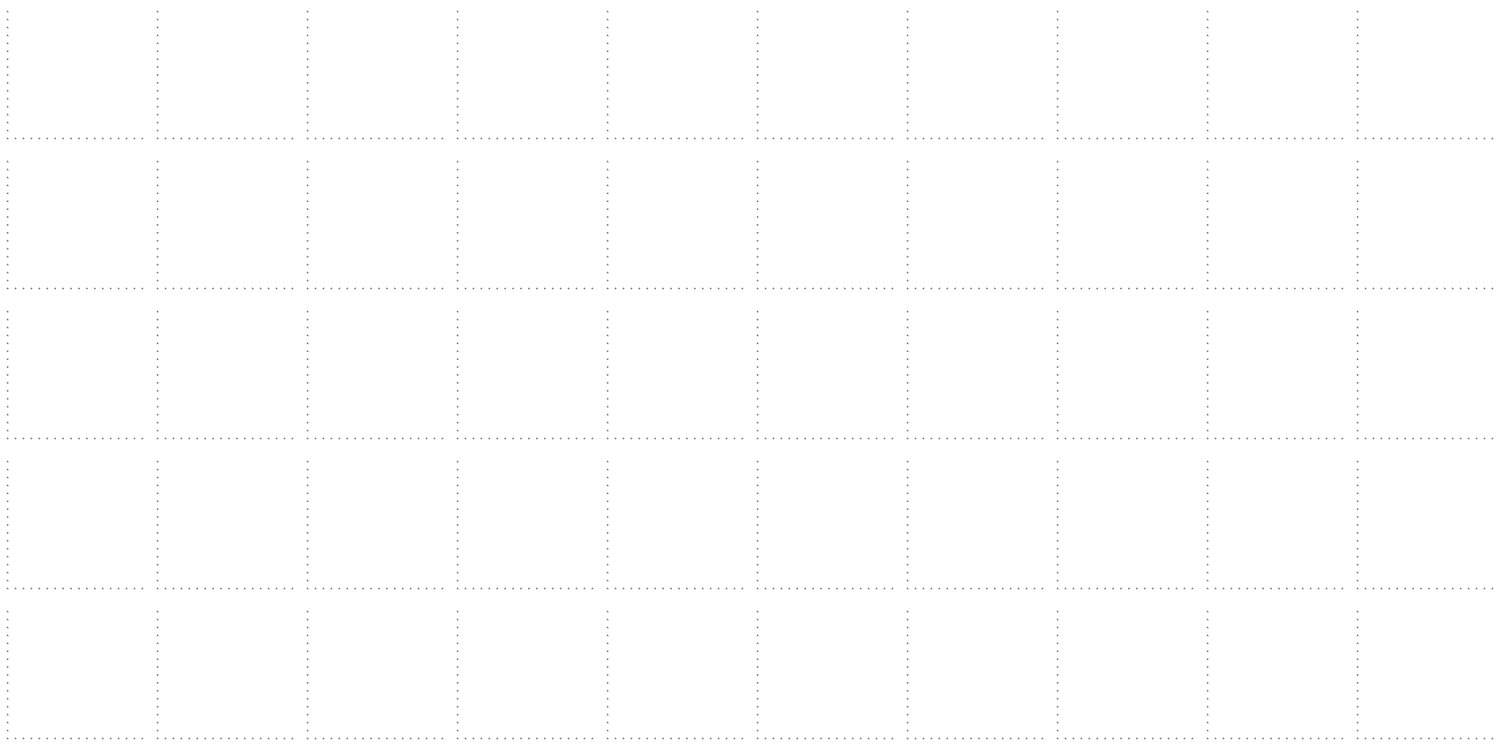

In [3]:
def visualizar_moleculas(mols, mols_por_fila=5, guardar_como=None):
    img = mols2grid_image(mols, mols_por_fila)
    print("Tipo de objeto devuelto:", type(img))  # <<< Añade esto

    if guardar_como:
        try:
            img.save(guardar_como)
        except Exception as e:
            print(f"No se pudo guardar la imagen: {e}")
    else:
        try:
            img.show()
        except AttributeError:
            from IPython.display import display
            display(img)

mols = samples(data, model, session, model.sample_z(50), sample=True)
visualizar_moleculas(mols, mols_por_fila=10)


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
import os

def guardar_moleculas_grid(mols, mols_por_fila=5, nombre_archivo="output.png", subImgSize=(200, 200)):
    """
    Genera y guarda una imagen de moléculas en una grilla como imagen PNG.
    """
    mols = [m for m in mols if m is not None]

    img = Draw.MolsToGridImage(
        mols,
        molsPerRow=mols_por_fila,
        subImgSize=subImgSize,
        useSVG=False,
        returnPNG=False
    )

    os.makedirs(os.path.dirname(nombre_archivo), exist_ok=True)

    img.save(nombre_archivo)

for i in range(1, 3):
    mols = samples(data, model, session, model.sample_z(50), sample=True)
    filename = f"Model_Output/Output_{i}.png"
    guardar_moleculas_grid(mols, mols_por_fila=10, nombre_archivo=filename)



✅ Imagen guardada como: Model_Output/Output_1.png
✅ Imagen guardada como: Model_Output/Output_2.png


In [ ]:
mols